In [96]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import types
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors

In [2]:
#layers at fixed z, giving x position
#source has x,z,px,pz
# B=1.45

#each tracker module has 4 layers of 32 straws, 8 modules in a station
#straw tube is 5mm diameter
#muons decay 5-10m from first layer
#momentum (0.5-3)e3 MeV
#300 mu-m radial position resolution
#4cm between outer layers of one module
#~6cm from center of module to edge?
#1mm between the two U-layers


#layers of 32 5mm bins, 1mm separated, 1cm between "twin" layers
#
# __ __ __ __
#__ __ __ __
#
#__ __ __ __
# __ __ __ __

#2cm between U and V, 4cm between modules

det_zs = np.ones((8,4))
det_zs[:,0] *= 0
det_zs[:,2] *= 3
det_zs[:,3] *= 4
for i in range(1,8):
    det_zs[i] += i*8
det_zs = det_zs.flatten()*1e-2
    
N_bins = 32
N_det = len(det_zs)

det_xs = np.tile(np.array([(i*6+2.5)*1e-3 for i in range(32)]),(N_det,1)) #i = z, j = x
#leftshift_idx = [1,2,5,6,9,10,13,14] #i//2 even and i%2 odd or i//2 odd and i%2 even
det_xs[[((i//2)%2 == 0 and (i%2) == 1) or ((i//2)%2 == 1 and (i%2) == 0) for i in range(N_det)]] -= 2.5e-3
det_xs += (4.5 + 2)*1e-2 #distance to storage volume center

### Tracker toy model

Muon decaying at (x,z), producing positron with momentum p in z-direction. $\vec{B} = B\hat{y}$

Since the Lorentz force only acts perpendicular to the direction of motion, $|v|$ and $\gamma$ don't change, and the time derivative is simply
$\frac{d\vec{v}}{dt} = \frac{q}{\gamma m} (\vec{v} \times \vec{B}) = \frac{qB}{\gamma m} (v_x \hat{z} - v_z\hat{x})$

$v_x = A\sin(\frac{qB}{\gamma m} t + \phi)$<br/>
$v_z = A\cos(\frac{qB}{\gamma m} t + \phi)$

$|v|^2 = v_x^2 + v_z^2 = A^2$<br/>
$p_x = p\sin(\frac{qB}{\gamma m} t)$<br/>
$p_z = p\cos(\frac{qB}{\gamma m} t)$

$x = \int_0^T v_x dt = -\frac{\gamma m}{qB} |v| (\cos(\frac{qB}{\gamma m} T + \phi) - \frac{v_z(0)}{|v|})$<br/>
$z = \int_0^T v_z dt = \frac{\gamma m}{qB} |v| (\sin(\frac{qB}{\gamma m} T + \phi) - \frac{v_x(0)}{|v|})$

$z$ is fixed, so<br/>
$T = \frac{\gamma m}{qB}(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|}) - \phi)$

$x = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\cos(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})) = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\sqrt{1 - (\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})^2} = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2|v|^2 - (qBz +\gamma mv_x(0))^2}$<br/>
$x = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2v_z^2(0) - q^2B^2z^2 -2qBz\gamma mv_x(0)} = \frac{p_z(0)}{qB} - \frac{1}{qB}\sqrt{p_z^2(0) - q^2B^2z^2 -2qBzp_x(0)}$

Change to use $|p|(0) = p$ and initial angle $\phi$ (from the z-axis):<br/>
$x = \frac{p\cos(\phi)}{qB} - \frac{1}{qB}\sqrt{p^2\cos^2(\phi) - q^2B^2z^2 -2qBzp\sin(\phi)}$

In [50]:
is_full_p = False

#leave out e in momentum calc, and q's above

c = constants.c
#e = constants.e
B = 1.45
#phi = lambda vx,vz: np.arctan2(vx,vz)

def calc_x(x,z,p):
    # p is in GeV -> *1e9/c
    if not is_full_p: p = p*1e9/c
    sq = p**2 - B**2*z**2
    #sq[sq<0] = -1 #won't register in any station
    sq[sq>=0] = np.sqrt(sq[sq>=0])
    
    res = (p - sq)/B + x
    res[sq<0] = -1

    return res

#def calc_x(z,p,phi):
#    # p is in GeV -> *1e9/c
#    if not is_full_p: p = p*1e9/c
#    sq = p**2*np.cos(phi)**2 - B**2*z**2 - 2*B*z*p*np.sin(phi)
#    sq[sq>0] = np.sqrt(sq[sq>0])
#    
#    res = (p*np.cos(phi) - sq)/B
#    res[sq<0] = -1
#    
#    return res

z_toy = -0.7
#z_toy = -0.94
p_toy = 1.9
if is_full_p: p_toy *= 1e9/c
x_toy = 0
#phi_toy = 0.025

sigma = 3e-4

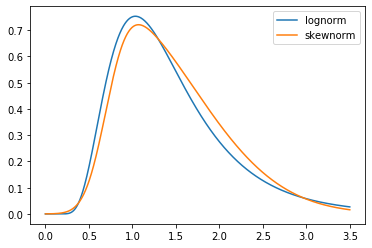

In [4]:
#p - start also with truncnorm to make easier

lnorm = stats.lognorm(0.5,loc=0.1,scale=1.2)
snorm = stats.skewnorm(5,loc=0.7,scale=1)
times = np.linspace(0,3.5, 1000)
plt.plot(times,lnorm.pdf(times),label='lognorm')
plt.plot(times,snorm.pdf(times),label='skewnorm')
plt.legend()
plt.show()

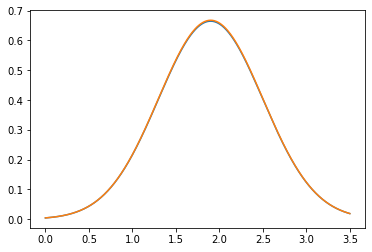

In [5]:
#p alt

norm = stats.norm(loc=1.9,scale=0.6)
tnorm = stats.truncnorm(-1.9/0.6,1.6/0.6,loc=1.9,scale=0.6)
times = np.linspace(0,3.5, 1000)
plt.plot(times,norm.pdf(times))
plt.plot(times,tnorm.pdf(times))
plt.show()

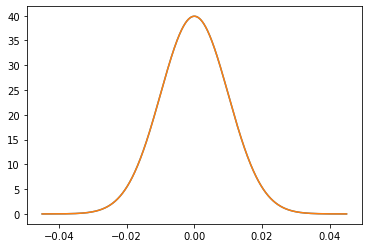

In [6]:
#x

norm = stats.norm(scale=0.01)
tnorm = stats.truncnorm(-4.5,4.5,scale=0.01)
times = np.linspace(-4.5e-2,4.5e-2, 1000)
plt.plot(times,norm.pdf(times))
plt.plot(times,tnorm.pdf(times))
plt.show()

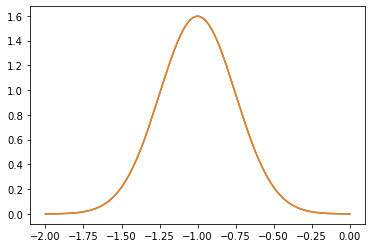

In [70]:
#z

norm = stats.norm(loc=-1,scale=0.25)
tnorm = stats.truncnorm(-4,4,loc=-1,scale=0.25)
times = np.linspace(0,-2, 1000)
plt.plot(times,norm.pdf(times))
plt.plot(times,tnorm.pdf(times))
plt.show()

In [71]:
def generate_event(x, z, p):
#def generate_event(z,p,phi):
    '''
    generates event
    
    Parameters:
    
    z : float
        Vertex position
    p : float
        Initial momentum
    phi : float
        Initial angle (with z-axis)
        
    Returns:
    
    xs : numpy array
        observed x-position per detector
    '''
    
    hits = []
    dist = det_zs-z
    x_exp = calc_x(x,dist,p)
    #x_exp = calc_x(dist,p,phi)
    for i in range(N_det):
        #check if x_exp < or > than end of detector
        if x_exp[i] < -2.5e-3 or x_exp[i] > det_xs[i,-1]+2.5e-3: continue
        
        #figure out which bin it would hit
        j = (np.abs(det_xs[i] - x_exp[i])).argmin()
        if np.abs(x_exp[i]-det_xs[i,j]) <= 2.5e-3:
            hits.append([det_xs[i,j],det_zs[i]])
    return np.asarray(hits)

#toy MC
def MC_events(N_events, xlims=(-2.5e-2,2.5e-2), zlims=(-1, -0.5), plims=(0.5,3.5),verbose_lvl = 0):
#def MC_events(N_events, zlims=(-1, -0.001), plims=(1.5,3),phi_lims=(0,np.pi/8)):
    '''
    sample source parameters from uniform distribution of x, p, and phi #isn't really uniform dist
    and generate events using those.
    N_events : int
        number of desired events
    *_lims : tuple
        lower and upper bount of the uniform to sample from
        
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array z,p,phi
    # p is in GeV -> *1e9/c
    
    #check if particle produces at least 5 hits (3 layers)
    
    x = []
    z = []
    p = []
    #phi = []
    events = []
    
    while len(events)<N_events:
        n_evs = N_events-len(events)
        if verbose_lvl == 2:
            print("# events done:",len(events))
            print("# events to go:",n_evs)
        _x = stats.truncnorm(-4.5,4.5,scale=0.01).rvs(n_evs)
        _z = stats.truncnorm(-4,4,loc=-1,scale=0.25).rvs(n_evs)
        _p = stats.truncnorm(-1.9/0.6,1.6/0.6,loc=1.9,scale=0.6).rvs(n_evs)
        #_x = np.random.uniform(*xlims,size=n_evs) #should be Gaussian
        #_z = np.random.uniform(*zlims,size=n_evs) #should be Gaussian
        #_p = np.random.uniform(*plims,size=n_evs)
        #_p = stats.skewnorm(5,loc=0.7).rvs()
        if is_full_p: _p *= 1e9/c
#        i=0
#        while i<N_events:
        #_phi = np.random.uniform(*phi_lims)
        for i in range(n_evs):
            _ev = generate_event(_x[i],_z[i],_p[i])
        #_ev = generate_event(_z,_p,_phi)
        
            if len(_ev)>4:
                x.append(_x[i])
                z.append(_z[i])
                p.append(_p[i])
                #phi.append(_phi) #was _p maybe that's why wrong
                events.append(_ev)
            if verbose_lvl >= 1:
                if len(events)%(N_events//10) == 0: print(N_events//10,"events done")
#                i+=1
        if verbose_lvl == 2:
            print("# events thrown out:",N_events - len(events))
    
    #truth = np.asarray([z, p, phi]).T
    truth = np.asarray([x, z, p]).T
    assert truth.shape[0] == len(events)
        
    return events, truth

In [9]:
def plot_event(ev):
    #plt scatter, then scatter event in red on top
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for i in range(N_det):
        ax.scatter(det_xs[i],np.ones(N_bins)*det_zs[i],marker="_",s=100,color="grey")
    ax.scatter(ev[:,0],ev[:,1],marker="_",s=100,color="red")
    
    #ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

[[0.071  0.09  ]
 [0.077  0.11  ]
 [0.0795 0.12  ]
 [0.0855 0.16  ]
 [0.089  0.17  ]
 [0.0915 0.2   ]
 [0.1035 0.24  ]
 [0.107  0.27  ]
 [0.1095 0.28  ]
 [0.1215 0.32  ]
 [0.125  0.33  ]
 [0.1395 0.4   ]
 [0.143  0.41  ]
 [0.149  0.43  ]
 [0.1515 0.44  ]
 [0.1635 0.48  ]
 [0.167  0.49  ]
 [0.173  0.51  ]
 [0.1755 0.52  ]
 [0.1875 0.56  ]
 [0.191  0.57  ]
 [0.197  0.59  ]
 [0.1995 0.6   ]]


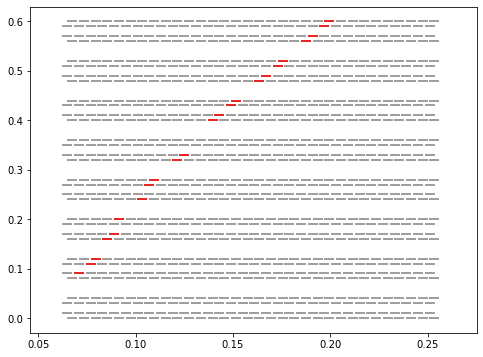

In [52]:
ev = generate_event(x_toy,z_toy,p_toy)
#ev = generate_event(-4e-2,-0.8,1.5)
#ev = generate_event(z_toy,p_toy,phi_toy)
#ev = generate_event(-0.63,2.9,0.015)
print(ev)
plot_event(ev)

In [11]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    #from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar

def plot_1d_scan(llh_scan_res, xs, true_x, axis_label, vmax=None):
    dom_terms = np.copy(llh_scan_res)
    
    #fig, ax = plt.subplots()
    
    # subtract minimum value from each scan result
    dom_terms -= dom_terms.min()
    #if not vmax: vmax = dom_terms.max()
    
    plt.plot(xs,dom_terms,label='scan')
    plt.axvline(x=true_x,color='red',label='truth')
    #ax[0].plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
    #ax[1].plot([true_x], [true_y], marker='$T$', markersize=10, color='black')
    
    plt.xlabel(axis_label)
    #plt.title(f'Log Likelihood (Gaussian)')
    plt.legend()


def plot_2d_scan(llh_scan_res, xs, ys, true_x, true_y, axis_labels, vmax=None, log=True):
    # copy to avoid modifying original scan results
    dom_terms = np.copy(llh_scan_res)
    
    if log: fig, ax = plt.subplots(1,2,figsize=(14,5)); plt.subplots_adjust(wspace=0.5)
    else: fig,ax = plt.subplots()
    gridsize = len(xs)
    
    # subtract minimum value from each scan result
    dom_terms -= dom_terms.min()
    #if not vmax: vmax = dom_terms.max()
    
    if not log: ax = [ax]
    m = ax[0].pcolormesh(xs, ys, dom_terms.reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, linewidth=0, vmin=0, vmax=vmax)
    
    if log:
        mlog = ax[1].pcolormesh(xs, ys, dom_terms.reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, linewidth=0, norm=colors.LogNorm(vmin=1e-3, vmax=vmax))
        
    ax[0].plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
    if log: ax[1].plot([true_x], [true_y], marker='$T$', markersize=10, color='black')
    
    for axis in ax:
        axis.set_xlabel(axis_labels[0])
        axis.set_ylabel(axis_labels[1])
        #axis.set_title(f'Log Likelihood (Gaussian)')
    colorbar(m)
    if log: colorbar(mlog)

In [12]:
grid_spacing = 100

xs = np.linspace(-2e-2,2e-2,grid_spacing)

#zs = np.linspace(-1, -0.5, grid_spacing)
zs = np.linspace(-1, -0.5, grid_spacing)
#ps = np.linspace(1.5, 2.5, grid_spacing)
ps = np.linspace(1.5, 2.5, grid_spacing)
if is_full_p: ps *= 1e9/c
#phis = np.linspace(0.01, 0.06, grid_spacing)

In [72]:
N_mc = 1000000
mc, truth = MC_events(N_mc,verbose_lvl=2)
#mc is [x,z] array

# events done: 0
# events to go: 1000000
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
100000 events done
# events thrown out: 159486
# events done: 840514
# events to go: 159486
100000 events done
# events thrown out: 25572
# events done: 974428
# events to go: 25572
# events thrown out: 4072
# events done: 995928
# events to go: 4072
# events thrown out: 656
# events done: 999344
# events to go: 656
# events thrown out: 93
# events done: 999907
# events to go: 93
# events thrown out: 12
# events done: 999988
# events to go: 12
100000 events done
# events thrown out: 0


In [115]:
#neural nets

hitnet = types.SimpleNamespace() 

hitnet.events = mc
n_hits_per_event = []

for item in mc:
    n_hits_per_event.append(item.shape[0])

hitnet.events = np.concatenate(hitnet.events)
n_hits_per_event = np.array(n_hits_per_event)
hitnet.events = np.vstack((hitnet.events.T,np.repeat(n_hits_per_event,n_hits_per_event))).T

hitnet.truth = np.repeat(truth, n_hits_per_event, axis=0)

assert hitnet.events.shape[0] == hitnet.truth.shape[0]

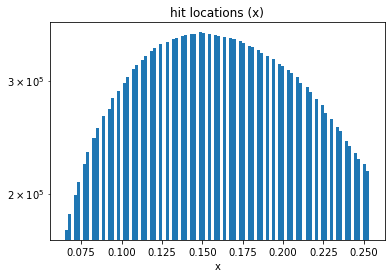

In [74]:
plt.hist(hitnet.events[:,0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit locations (x)')
plt.xlabel('x')
plt.show()

In [16]:
def make_dataset(x, t, shuffle_block_size=2**15, batch_size=2**12):
        '''
        get a tensorflow dataset for likelihood approximation
        
        Parameters:
        -----------
        x : ndarray
            observations
        t : ndarray
            parameters        
        shuffle_block_size : int
            block size over which to shuffle, should be multiple of batch_size
        batch_size : int
        
        Returns:
        --------
        
        tf.data.Dataset
            with structure ((x, t), y) for training
        
        '''
        
        N = x.shape[0]
        assert t.shape[0] == N
        
        d_x = tf.data.Dataset.from_tensor_slices(x)
        d_t = tf.data.Dataset.from_tensor_slices(t)

        d_true_labels = tf.data.Dataset.from_tensor_slices(np.ones((N, 1), dtype=x.dtype))
        d_false_labels = tf.data.Dataset.from_tensor_slices(np.zeros((N, 1), dtype=x.dtype))

        d_xs = tf.data.Dataset.from_tensor_slices([d_x, d_x]).interleave(lambda x : x)
        d_ts = tf.data.Dataset.from_tensor_slices([d_t, d_t.shuffle(shuffle_block_size)]).interleave(lambda x : x)
        d_ys = tf.data.Dataset.from_tensor_slices([d_true_labels, d_false_labels]).interleave(lambda x : x)
        
        
        dataset = tf.data.Dataset.zip((tf.data.Dataset.zip((d_xs, d_ts)), d_ys))
  
        return dataset.batch(batch_size)



In [116]:
## charge net

hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)
hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)

In [117]:
class trafo(tf.keras.layers.Layer):

    def call(self, hits, theta):
        dz = hits[:,1]-theta[:,1]
        dx = hits[:,0]-theta[:,0]
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 hits[:,2],
                 #dx,dz,
                 #px,
                 #pz,
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )
#        out = tf.concat([charges[:,:1],r2,theta],axis=1)
        return out

#class trafo(tf.keras.layers.Layer):
#    def call(self, hits, theta):
#        locs = detector_loc(N_det)
#        r2 = tf.math.square(locs - tf.reshape(theta[:,0],[-1,1])) + tf.math.square(tf.reshape(theta[:,1],[-1,1]))
#        out = tf.concat([hits,r2,theta],axis=1)
        #out = tf.concat([hits,theta],axis=1)
#        return out
    
hitnet.trafo = trafo

In [118]:
activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

#h = tf.keras.layers.Dense(8, activation=activation)(h)

h = tf.keras.layers.Dense(16, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(64, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(128, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(64, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(32, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(16, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(8, activation=activation)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo_3 (trafo)                 (None, 6)            0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 16)           112         trafo_3[0][0]              

In [119]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [120]:
#n_epochs = 5
#for i in range(n_epochs):
#    hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
#    hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)
#    hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=1, verbose=1, validation_data=hitnet.d_test)

hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=5, verbose=1, validation_data=hitnet.d_test)

Epoch 1/5
7452/7452 [==============================] - 549s 73ms/step - loss: 0.4612 - val_loss: 0.1085
Epoch 2/5
7452/7452 [==============================] - 599s 80ms/step - loss: 0.1362 - val_loss: 0.0928
Epoch 3/5
7452/7452 [==============================] - 569s 76ms/step - loss: 0.1385 - val_loss: 0.1046
Epoch 4/5
7452/7452 [==============================] - 484s 65ms/step - loss: 0.1402 - val_loss: 0.0961
Epoch 5/5
7452/7452 [==============================] - 518s 69ms/step - loss: 0.1409 - val_loss: 0.0883


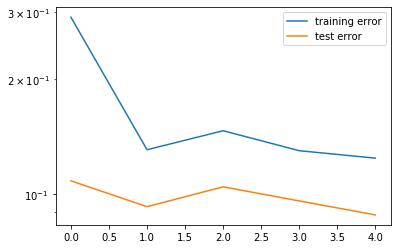

In [121]:
plt.plot(hitnet.model.history.history['loss'],label='training error')
plt.plot(hitnet.model.history.history['val_loss'],label='test error')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

In [62]:
_x = stats.truncnorm(-4.5,4.5,scale=0.01).pdf(xs)
_z = stats.truncnorm(-4,4,loc=1,scale=0.25).pdf(zs)
_p = stats.truncnorm(-1.9/0.6,1.6/0.6,loc=1.9,scale=0.6).pdf(ps)

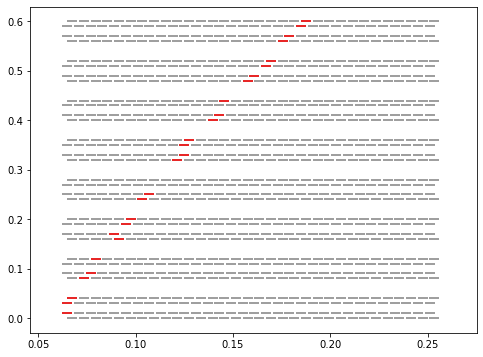

In [46]:
x_toy = np.random.uniform(-2.5e-2,2.5e-2) #should be Gaussian
z_toy = np.random.uniform(-1, -0.5) #should be Gaussian
p_toy = np.random.uniform(0.5,3.5)

ev = generate_event(x_toy,z_toy,p_toy)
plot_event(ev)

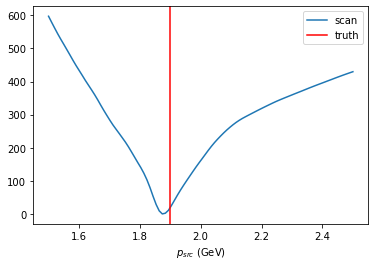

In [123]:
scan_t = np.vstack([np.ones(grid_spacing)*x_toy,np.ones(grid_spacing)*z_toy,ps]).T
scan_t = np.repeat(scan_t,len(ev),axis=0)

scan_x = np.tile(ev[:,0],grid_spacing)
scan_x = np.vstack((scan_x,np.tile(ev[:,1],grid_spacing),len(ev)*np.ones(grid_spacing*len(ev)))).T

nn_p_scan = hitnet.llh.predict([scan_x,scan_t])

nn_p_scan = -np.sum(nn_p_scan.reshape(-1,len(ev)),axis=1)
plot_1d_scan(nn_p_scan, ps, p_toy, axis_label='$p_{src}$ (GeV)')

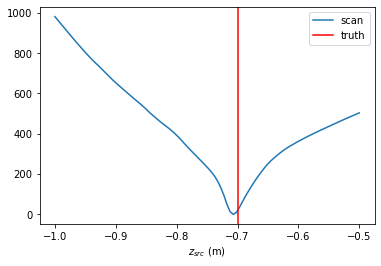

In [124]:
scan_t = np.vstack([np.ones(grid_spacing)*x_toy,zs,np.ones(grid_spacing)*p_toy]).T
scan_t = np.repeat(scan_t,len(ev),axis=0)

scan_x = np.tile(ev[:,0],grid_spacing)
scan_x = np.vstack((scan_x,np.tile(ev[:,1],grid_spacing),len(ev)*np.ones(grid_spacing*len(ev)))).T

nn_z_scan = hitnet.llh.predict([scan_x,scan_t])

nn_z_scan = -np.sum(nn_z_scan.reshape(-1,len(ev)),axis=1)
plot_1d_scan(nn_z_scan, zs, z_toy, axis_label='$z_{src}$ (m)')

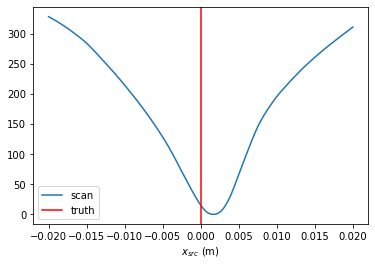

In [125]:
scan_t = np.vstack([xs,np.ones(grid_spacing)*z_toy,np.ones(grid_spacing)*p_toy]).T
scan_t = np.repeat(scan_t,len(ev),axis=0)

scan_x = np.tile(ev[:,0],grid_spacing)
scan_x = np.vstack((scan_x,np.tile(ev[:,1],grid_spacing),len(ev)*np.ones(grid_spacing*len(ev)))).T

#nn_phi_scan = hitnet.llh.predict([scan_x,scan_t])
nn_x_scan = hitnet.llh.predict([scan_x,scan_t])

#nn_phi_scan = -np.sum(nn_phi_scan.reshape(-1,len(ev)),axis=1)
#plot_1d_scan(nn_phi_scan, phis, phi_toy, axis_label=r'$\varphi_{src}$ (rad)')
nn_x_scan = -np.sum(nn_x_scan.reshape(-1,len(ev)),axis=1)
plot_1d_scan(nn_x_scan, xs, x_toy, axis_label='$x_{src}$ (m)')

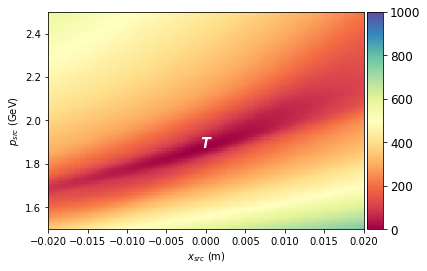

In [126]:
#change phi to x

mg = np.meshgrid(xs,ps)

hitnet.grid_t = np.vstack([mg[0].flatten(),np.ones(grid_spacing**2)*z_toy,mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,len(ev),axis=0)

hitnet.grid_x = np.tile(ev[:,0],grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(ev[:,1],grid_spacing**2),len(ev)*np.ones(grid_spacing**2*len(ev)))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_x_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, len(ev)), axis=1)
plot_2d_scan(NN_x_p_scan, xs, ps, x_toy, p_toy, 
            axis_labels=['$x_{src}$ (m)','$p_{src}$ (GeV)'], vmax=1000, log=False)

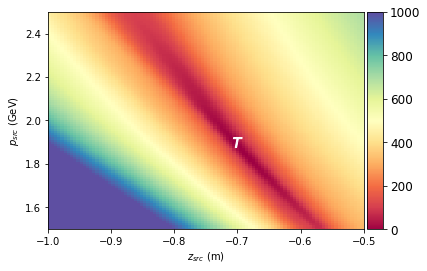

In [127]:
mg = np.meshgrid(zs,ps)

hitnet.grid_t = np.vstack([np.ones(grid_spacing**2)*x_toy,mg[0].flatten(),mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,len(ev),axis=0)

hitnet.grid_x = np.tile(ev[:,0],grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(ev[:,1],grid_spacing**2),len(ev)*np.ones(grid_spacing**2*len(ev)))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, len(ev)), axis=1)
plot_2d_scan(NN_z_p_scan, zs, ps, z_toy, p_toy, 
            axis_labels=['$z_{src}$ (m)', '$p_{src}$ (GeV)'], vmax=1000, log=False)

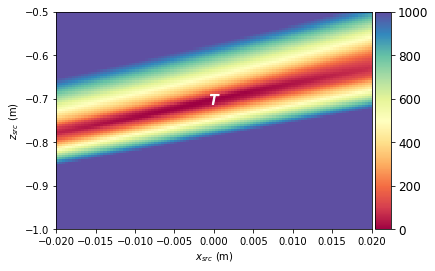

In [86]:
mg = np.meshgrid(xs,zs)

hitnet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*p_toy]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,len(ev),axis=0)

hitnet.grid_x = np.tile(ev[:,0],grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(ev[:,1],grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_x_z_scan = -np.sum(hitnet.grid_llh.reshape(-1, len(ev)), axis=1)
plot_2d_scan(NN_x_z_scan, xs, zs, x_toy, z_toy, 
            axis_labels=['$x_{src}$ (m)', '$z_{src}$ (m)'], vmax=1000, log=False)

In [128]:
def llh_fun(theta,event):
    #theta is array [x,z,p]
    #event is nx2 array
    
    params = np.tile(theta,len(event)).reshape((len(event),-1))
    #print(params) 
    obs = np.vstack((event.T,len(event)*np.ones(len(event)))).T
    
    #pred = hitnet.llh.predict([event,params])
    pred = hitnet.llh.predict([obs,params])
    #print(pred)
    return -np.sum(pred)

In [129]:
print(x_toy,z_toy,p_toy)
print(llh_fun([x_toy,z_toy,p_toy],ev))

0 -0.7 1.9
-68.269714


In [130]:
opt_params = minimize(llh_fun,[2e-2,-1,2],args=(ev),method='Nelder-Mead',options={'maxiter':100000,'disp':True})

print(opt_params)

Optimization terminated successfully.
         Current function value: -90.735886
         Iterations: 154
         Function evaluations: 276
 final_simplex: (array([[ 0.01546124, -0.56505225,  1.63013997],
       [ 0.01545686, -0.5650882 ,  1.63020563],
       [ 0.01545716, -0.56508963,  1.63021287],
       [ 0.01545512, -0.56510496,  1.63023694]]), array([-90.73588562, -90.73586273, -90.7358551 , -90.73584747]))
           fun: -90.73588562011719
       message: 'Optimization terminated successfully.'
          nfev: 276
           nit: 154
        status: 0
       success: True
             x: array([ 0.01546124, -0.56505225,  1.63013997])


In [131]:
opt_params = minimize(llh_fun,[2e-2,-1,2],args=(ev),method='Powell',options={'maxiter':100000,'disp':True})

print(opt_params)

Optimization terminated successfully.
         Current function value: -77.591843
         Iterations: 9
         Function evaluations: 563
   direc: array([[ 0.00651935, -0.00196514,  0.04296597],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.00838111,  0.00834017,  0.08769475]])
     fun: -77.59184
 message: 'Optimization terminated successfully.'
    nfev: 563
     nit: 9
  status: 0
 success: True
       x: array([-0.0362007 , -0.9893893 ,  2.38014716])


In [132]:
opt_params = minimize(llh_fun,[0,-0.5,2],args=(ev),method='Nelder-Mead',options={'maxiter':100000,'disp':True})

print(opt_params)

Optimization terminated successfully.
         Current function value: -90.734039
         Iterations: 161
         Function evaluations: 286
 final_simplex: (array([[ 0.01550725, -0.56459389,  1.62916073],
       [ 0.01550083, -0.56464296,  1.62924118],
       [ 0.01551024, -0.56456448,  1.62910372],
       [ 0.01550228, -0.56462747,  1.62920817]]), array([-90.73403931, -90.73403168, -90.73401642, -90.73397827]))
           fun: -90.73403930664062
       message: 'Optimization terminated successfully.'
          nfev: 286
           nit: 161
        status: 0
       success: True
             x: array([ 0.01550725, -0.56459389,  1.62916073])


In [134]:
opt_params = minimize(llh_fun,[0,-0.5,2],args=(ev),method='Powell',options={'maxiter':100000,'disp':True})

print(opt_params)

Optimization terminated successfully.
         Current function value: -90.707191
         Iterations: 6
         Function evaluations: 371
   direc: array([[-1.43322687e-02, -3.25604745e-02, -4.23031482e-02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-8.20288802e-05, -1.74954793e-04, -8.55626947e-04]])
     fun: -90.70719
 message: 'Optimization terminated successfully.'
    nfev: 371
     nit: 6
  status: 0
 success: True
       x: array([ 0.01326218, -0.58311911,  1.66145207])


In [135]:
#test if result from minimizer gives same event?
test_ev = generate_event(*opt_params.x)
print(ev)
print(test_ev)

[[0.071  0.09  ]
 [0.077  0.11  ]
 [0.0795 0.12  ]
 [0.0855 0.16  ]
 [0.089  0.17  ]
 [0.0915 0.2   ]
 [0.1035 0.24  ]
 [0.107  0.27  ]
 [0.1095 0.28  ]
 [0.1215 0.32  ]
 [0.125  0.33  ]
 [0.1395 0.4   ]
 [0.143  0.41  ]
 [0.149  0.43  ]
 [0.1515 0.44  ]
 [0.1635 0.48  ]
 [0.167  0.49  ]
 [0.173  0.51  ]
 [0.1755 0.52  ]
 [0.1875 0.56  ]
 [0.191  0.57  ]
 [0.197  0.59  ]
 [0.1995 0.6   ]]
[[0.065  0.03  ]
 [0.0735 0.08  ]
 [0.071  0.09  ]
 [0.077  0.11  ]
 [0.0795 0.12  ]
 [0.0855 0.16  ]
 [0.089  0.17  ]
 [0.1035 0.24  ]
 [0.107  0.25  ]
 [0.1095 0.28  ]
 [0.1215 0.32  ]
 [0.125  0.33  ]
 [0.131  0.35  ]
 [0.1335 0.36  ]
 [0.1395 0.4   ]
 [0.143  0.41  ]
 [0.149  0.43  ]
 [0.1515 0.44  ]
 [0.1635 0.48  ]
 [0.167  0.49  ]
 [0.173  0.51  ]
 [0.1755 0.52  ]
 [0.1875 0.56  ]
 [0.191  0.57  ]
 [0.197  0.59  ]
 [0.1995 0.6   ]]


In [ ]:
#have to include probability of not hitting too!